In [1]:
import numpy as np
import pandas as pd
import pickle
import os
from mpl_toolkits.basemap import Basemap
from descartes.patch import PolygonPatch
from shapely.geometry import Polygon, MultiPolygon, LineString, Point, MultiPoint
import matplotlib.pyplot as plt
import matplotlib.patches as plt_patch
import re
import dateutil.parser as parser
%matplotlib inline

In [2]:
def extract_wx_polygon(archive, archive_name):
    '''
    daily operational time: 92.2 ms ± 1.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
    '''
#     fname_abs = os.path.join(root_dir, 'TFM+ncwf_TFM$01_jan_0950$_20130101_095000')
#     with open(fname_abs, 'rb') as wx: # if work with extracted files
#     otherwise, archive = zipfile.ZipFile('NCWF/DATA/2013/201301/20130101/TFM+NCWF_TFM_20130101_230627.zip')
    with archive.open(archive_name) as wx:
        text = wx.readlines()
        storm_results = []
        detect_results = []
        altitude_results = []
        cursor = 0
        storm_count = 0
        while True:
            try:
                line = text[cursor].decode('utf-8')
                if line.startswith('# Issue Time'):
                    time_string = line[14:]
                    cursor += 1
                elif line == 'STORM\n':
                    storm_count += 1
                    cursor += 1
                    line = text[cursor].decode('utf-8')
                    storm_info = re.findall('[-+]?[0-9]*\.?[0-9]+', line)
                    storm_idx = storm_count
                    alt = storm_info[-1]
                    altitude_results.append(alt)
                    while True:
                        cursor += 1
                        line = text[cursor].decode('utf-8')
                        coord = re.findall('[-+]?[0-9]*\.?[0-9]+', line)
                        if len(coord) != 2:
                            break
                        storm_results.append([storm_idx] + coord)
                elif line == 'DETECTION\n':
                    cursor += 1
                    # centroid info is not useful
                    # line = text[cursor].decode('utf-8')
                    while True:
                        cursor += 1
                        line = text[cursor].decode('utf-8')
                        coord = re.findall('[-+]?[0-9]*\.?[0-9]+', line)
                        if len(coord) != 2:
                            break
                        detect_results.append([storm_idx] + coord)
                else:
                    cursor += 1
                    # print(line)
            except IndexError:
                break
        storm_results = np.array(storm_results).astype(np.float32) # [N, 3] --> [poly_id, lat, lon]
        detect_results = np.array(detect_results).astype(np.float32) # same as storm_results
        altitude_results = np.array(altitude_results).astype(np.float32) # (K,) --> altitude of all K storms
        file_time = parser.parse(time_string) # parsed time
        info_results = [file_time.year, file_time.month, file_time.day, file_time.hour, file_time.minute, storm_count]
        return storm_results, detect_results, altitude_results, info_results

In [3]:
import calendar
from shapely.ops import cascaded_union

In [4]:
def convert_to_polygons(polygon_coords, polygon_alt, polygon_info, alt_thres = 10, year_list = [2013]):
    '''
    Input:
    # polygon_coords is a np array of np arrays, each array is a N by 3 matrix which contains [polygon id, lat, lon]
    # polygon_info is a N by 6 np array which contains [year, month, day, hour, minute, # of polys]
    Return:
    results_multipoly_by_hour: list of list. [..., [poly1, poly2, ..., poly_n], ...]
    results_alt1000ft_by_hour: list of np.arrays. [..., [alt1, alt2, ..., alt_n], ...]
    results_time_with_poly: list of list. [..., [yyyy,mm,dd,hh], ...]
    
    all three lists have the same length: 
    assert len(results_multipoly_by_hour) == len(results_alt1000ft_by_hour) == len(results_time_with_poly)
    assert len(results_multipoly_by_hour[k]) == len(results_alt1000ft_by_hour[k]) for all k
    Daily operational time:
    160 ms ± 3.57 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
    '''
    results_multipoly_by_hour = []
    results_alt1000ft_by_hour = []
    results_time_with_poly = []    
    
    for year in year_list:
        for month in range(1, 13, 1):
            for day in range(1, calendar.monthrange(year, month)[-1] + 1, 1):
                for hour in range(24):
                    polys = []
                    alts = []
                    # search single poly indices for a specific day-hour
                    time_list = [year, month, day, hour]
                    poly_idx = np.where(((polygon_info[:, :4] == time_list).all(axis = 1))&
                                         (polygon_info[:, -1]>0))[0]
                    if poly_idx.size == 0:
                        pass
                    else:
#                         alts.append(polygon_alt[poly_idx])
                        for idx in poly_idx:
                            # print(idx)
                            if polygon_info[idx, -1] == 1:
                                polys.append(Polygon(polygon_coords[idx][:, [2,1]]))
                                alts.append(polygon_alt[idx][0]) # appends the altitude
                            elif polygon_info[idx, -1] > 1:
                                for i in range(polygon_info[idx, -1]):
                                    tmp_idx = np.where(polygon_coords[idx][:, 0] == (i+1))[0]
                                    polys.append(Polygon(polygon_coords[idx][tmp_idx][:, [2,1]]))
                                alts += polygon_alt[idx].tolist()
                                # pandas unique is faster than numpy unique, and also preserve order of the original list
                            else:
                                raise AssertionError
                        # TODO: union polygons with the similar altitude
                        # approach 1: (alt - alt.min())//alt_thres
                        # approach 2: use groupby function
                        # for k, g in itertools.groupby(nums, key=lambda n: (n - min(nums))//alt_thres):
                        #    print(k, list(g))
                        
                        alts_idx, unique_FL = combine_alt_idx(alts, alt_thres)
                        tmp_polys = []
                        for ele in alts_idx:
                            tmp_polys.append(cascaded_union([polys[element] for element in ele]))
#                         results_union_poly_by_hour.append(cascaded_union(polys))
#                         results_multipoly_by_hour.append(MultiPolygon(tmp_polys))
#                         results_alt1000ft_by_hour.append(alts)
                        results_multipoly_by_hour.append(tmp_polys)
                        results_alt1000ft_by_hour.append(unique_FL)
                        results_time_with_poly.append(time_list)                    
    return results_multipoly_by_hour, results_alt1000ft_by_hour, results_time_with_poly

def combine_alt_idx(alts_list, alt_thres):
    # util function called by convert_to_polygons
    alts_1000ft = np.array(alts_list)//alt_thres
    unique_FL = pd.unique(alts_1000ft)
    idx = []
    for ele in unique_FL:
        idx.append(np.where(alts_1000ft == ele)[0])
    return idx, unique_FL

In [5]:
import zipfile

In [385]:
root_dir = 'NCWF/DATA/2013/'
subfolder = os.listdir(root_dir)
i = 0
for yyyymm in subfolder:
    if yyyymm.startswith('2013'):
        second_folder = os.listdir(os.path.join(root_dir, yyyymm))
        for yyyymmdd in second_folder:
            if yyyymmdd.startswith('2013'):
                abs_fnames = os.listdir(os.path.join(root_dir, yyyymm, yyyymmdd))
#                 if len(abs_fnames) != 1:
#                     print(abs_fnames)
                for abs_fname in abs_fnames:
                    i += 1
                    if i % 30 == 0:
                        print('===================== processing %s =================='%abs_fname)
                    results_storm = []
                    results_detect = []
                    results_altitude = []
                    results_info = []
                    archive = zipfile.ZipFile(os.path.join(root_dir, yyyymm, yyyymmdd, abs_fname), 'r')
                    for single_archive_name in archive.namelist():
                        rs, rd, ra, ri = extract_wx_polygon(archive, single_archive_name)
                        results_storm.append(rs)
                        results_detect.append(rd)
                        results_altitude.append(ra)
                        results_info.append(ri)
                    results_storm = np.array(results_storm) # [N_file, M_coords, 3] --> [...,[poly_id, lat, lon],...]
                    results_detect = np.array(results_detect) # same as storm
                    results_altitude = np.array(results_altitude) # [N_file, K_alt]  --> [...,[alt1, alt2, ..., alt_m],...]
                    results_info = np.array(results_info) # [N_file, 6] --> [..., [year, month, day, hour, minute, # of polys], ...]
                    
                    s_poly, s_alt, s_time = convert_to_polygons(results_storm, results_altitude, results_info)
                    d_poly, d_alt, d_time = convert_to_polygons(results_detect, results_altitude, results_info)
                    with open('NCWF/ProcessedNCFW/storm_%s.pkl'%abs_fname[13:21], 'wb') as pfile:
                        pickle.dump((s_poly, s_alt, s_time), pfile)
                    with open('NCWF/ProcessedNCFW/detect_%s.pkl'%abs_fname[13:21], 'wb') as pfile:
                        pickle.dump((d_poly, d_alt, d_time), pfile)
                    archive.close()

===================== processing TFM+NCWF_TFM_20130219_224642.zip ==================
===================== processing TFM+NCWF_TFM_20130410_220140.zip ==================
===================== processing TFM+NCWF_TFM_20130530_195128.zip ==================
===================== processing TFM+NCWF_TFM_20130719_232526.zip ==================
===================== processing TFM+NCWF_TFM_20130907_184003.zip ==================
===================== processing TFM+NCWF_TFM_20131027_224324.zip ==================
===================== processing TFM+NCWF_TFM_20131217_214712.zip ==================


## test pkl file

In [2]:
def plot_daily_wx(nested_polygon_list):
    plt.figure(figsize=(10,6))
    m = Basemap(llcrnrlon = -128,llcrnrlat = 22.,urcrnrlon = -63,urcrnrlat = 52,projection='merc')
    m.drawmapboundary(fill_color='#8aeaff')
    m.fillcontinents(color='#c5c5c5', lake_color='#8aeaff')
    m.drawcoastlines(linewidth=0.5)
    m.drawcountries(linewidth=0.5)
    m.drawstates(linewidth=0.1)
    
    bad_poly = []
    i = -1
    for hr_poly in nested_polygon_list:
        i += 1
        j = -1
        for mpoly in hr_poly:
            j += 1
            if mpoly.geom_type is 'MultiPolygon':
                k = -1
                for poly in mpoly:
                    k += 1
                    try:
                        x,y = m(poly.exterior.coords.xy[0], poly.exterior.coords.xy[1])
                        xy = list(zip(x, y))
                        de_Poly = plt_patch.Polygon( xy, facecolor='yellow', alpha=0.9)
                        plt.gca().add_patch(de_Poly)
                    except Exception as err:
                        print(i,j,k)
                        print('MultiPolygon:%s, location: (%d, %d, %d)'%(err, i, j, k))
                        bad_poly.append(poly)
                        pass
            elif mpoly.geom_type is 'Polygon':
                try:
                    x,y = m(mpoly.exterior.coords.xy[0], mpoly.exterior.coords.xy[1])
                    xy = list(zip(x, y))
                    de_Poly = plt_patch.Polygon( xy, facecolor='yellow', alpha=0.9)
                    plt.gca().add_patch(de_Poly)
                except Exception as err:
                    print('Polygon:%s, location: (%d, %d)'%(err,i,j))
                    bad_poly.append(poly)
                    pass
            else:
                print(mpoly.geom_type)
    plt.title('NCWF convective weather polygons')
    return bad_poly

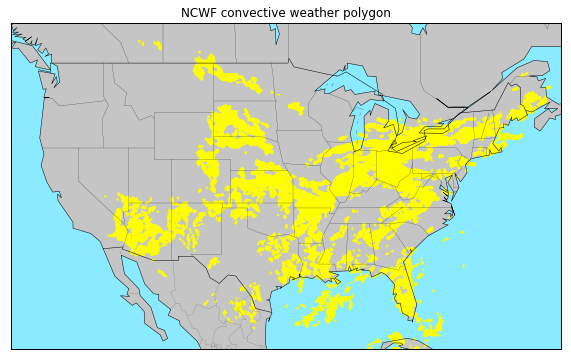

In [3]:
test_d_poly, test_d_alt, test_d_time = pickle.load(open('NCWF/ProcessedNCFW/storm_20130720.pkl', 'rb'))
bad_poly = plot_daily_wx(test_d_poly)

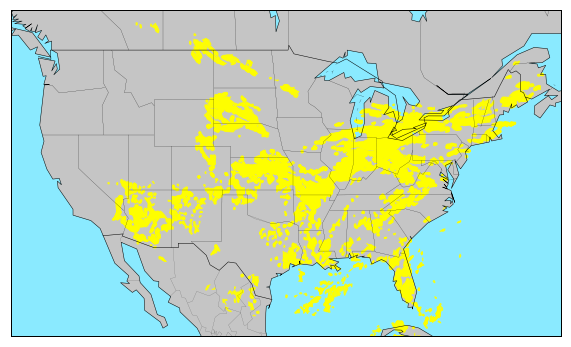

In [72]:
test_d_poly, test_d_alt, test_d_time = pickle.load(open('NCWF/ProcessedNCFW/detect_20130720.pkl', 'rb'))
bad_poly = plot_daily_wx(test_d_poly)

## Load and combine all pkl files into one big file.

In [278]:
root_dir = 'NCWF/ProcessedNCFW/'
i = 0
s_polys = []
s_alts = []
s_times = []
d_polys = []
d_alts = []
d_times = []
for fname in os.listdir(root_dir):
    if fname.startswith('storm'):
        with open(os.path.join(root_dir, fname), 'rb') as sfile:
            s_poly, s_alt, s_time = pickle.load(sfile)
            s_polys += s_poly
            s_alts += s_alt
            s_times += s_time
    elif fname.startswith('detect'):
        with open(os.path.join(root_dir, fname), 'rb') as dfile:
            d_poly, d_alt, d_time = pickle.load(dfile)
            d_polys += d_poly
            d_alts += d_alt
            d_times += d_time
    else:
        pass
    i += 1
    if i % 60 == 0:
        print('Ok for %d, %s'%(i, fname))

Ok for 60, detect_20130301.pkl
Ok for 120, detect_20130430.pkl
Ok for 180, detect_20130629.pkl
Ok for 240, detect_20130828.pkl
Ok for 300, detect_20131027.pkl
Ok for 360, detect_20131227.pkl
Ok for 420, storm_20130225.pkl
Ok for 480, storm_20130426.pkl
Ok for 540, storm_20130625.pkl
Ok for 600, storm_20130824.pkl
Ok for 660, storm_20131023.pkl
Ok for 720, storm_20131223.pkl


In [285]:
with open('NCWF/ProcessedNCFW_bundle/storm_bundle.pkl', 'wb') as psfile:
    pickle.dump((s_polys, s_alts, s_times), psfile)
with open('NCWF/ProcessedNCFW_bundle/detect_bundle.pkl', 'wb') as pdfile:
    pickle.dump((d_polys, d_alts, d_times), pdfile)

In [ ]:
with open('NCWF/ProcessedNCFW_bundle/storm_bundle.pkl', 'rb') as pfile:
    wx_bundle, alt_bundle, st_bundle = pickle.load(pfile)
    
st_holder = []
alt_holder = []
wx_holder = []
for i in range(len(wx_bundle)):
    if st_bundle[i] not in st_holder:
        st_holder.append(st_bundle[i])
        alt_holder.append(alt_bundle[i])
        wx_holder.append(wx_bundle[i])
    else:
        idx = st_holder.index(st_bundle[i])
        alt_holder[idx] = np.concatenate((alt_holder[idx], alt_bundle[i]))
        wx_holder[idx] = wx_holder[idx] + wx_bundle[i]
        
        unique_FL = pd.unique(alt_holder[idx])
        alts_idx = []
        for ele in unique_FL:
            alts_idx.append(np.where(alt_holder[idx] == ele)[0])
        
        tmp_polys = []
        for ele in alts_idx:
            tmp_polys.append(cascaded_union([wx_holder[idx][element] for element in ele])) 
        wx_holder[idx] = tmp_polys

In [23]:
with open('NCWF/one_hour.p', 'rb') as psfile:
    a = pickle.load(psfile, encoding='bytes')

In [79]:
test_d_time[12]

[2013, 7, 20, 11]

In [111]:
b = cascaded_union([geom for geom in test_d_poly[16]])
c = cascaded_union([geom for geom in a[b'20130720-15']])

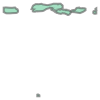

In [112]:
b.intersection(Point(-82.67841, 35.46673).buffer(5, cap_style = 3))

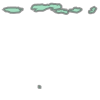

In [113]:
c

In [110]:
c.bounds

(-87.7646, 29.64595, -80.16176, 42.15889)

In [98]:
(-88.2381 -77.11872)/2
# (30.4082 + 40.52526)/2

-82.67841

In [30]:
a.keys()

dict_keys([b'20141228-17', b'20140513-11', b'20141228-15', b'20141228-14', b'20141228-13', b'20141228-12', b'20141228-11', b'20140513-10', b'20140513-13', b'20141228-19', b'20141228-18', b'20140513-12', b'20140513-15', b'20110708-15', b'20140513-17', b'20140513-16', b'20121027-05', b'20121027-04', b'20121027-07', b'20121027-06', b'20121027-01', b'20121027-00', b'20121027-03', b'20121027-02', b'20141217-15', b'20141217-14', b'20141217-17', b'20141217-16', b'20121027-09', b'20121027-08', b'20141217-13', b'20141217-12', b'20141219-21', b'20130211-13', b'20130211-12', b'20130211-11', b'20130211-10', b'20130211-17', b'20130211-16', b'20130211-15', b'20130211-14', b'20130211-19', b'20130211-18', b'20110208-19', b'20110208-18', b'20110208-13', b'20110208-12', b'20110208-11', b'20110208-10', b'20110208-17', b'20110208-16', b'20110208-15', b'20110208-14', b'20110602-08', b'20110602-09', b'20110602-02', b'20110602-03', b'20110602-00', b'20110602-01', b'20110602-06', b'20110602-07', b'20110602-04

### beta test with Traj.

In [295]:
traj = pd.read_csv(os.getcwd() + '/TFMS_NEW/New_IAHBOS2013.csv')

In [301]:
a = LineString(traj.loc[traj.FID == 20130101632288, ['Lon', 'Lat']].values)

In [312]:
b = MultiPoint(traj.loc[traj.FID == 20130101632288, ['Lon', 'Lat']].values)

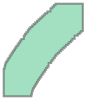

In [337]:
b[:40].buffer(1, cap_style=3)

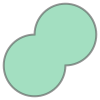

In [329]:
MultiPoint([Point(0,0), Point(1,1)]).buffer(1, join_style = 3)

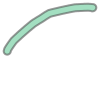

In [307]:
a.buffer(1, cap_style=1)

### beta $\beta$ test with extracted files

In [12]:
def extract_wx_polygon_from_extracted_file(fname_abs):
    '''
    daily operational time: 92.2 ms ± 1.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
    '''
#     fname_abs = os.path.join(root_dir, 'TFM+ncwf_TFM$01_jan_0950$_20130101_095000')
    with open(fname_abs, 'rb') as wx: # if work with extracted files
        text = wx.readlines()
        storm_results = []
        detect_results = []
        altitude_results = []
        cursor = 0
        storm_count = 0
        while True:
            try:
                line = text[cursor].decode('utf-8')
                if line.startswith('# Issue Time'):
                    time_string = line[14:]
                    cursor += 1
                elif line == 'STORM\n':
                    storm_count += 1
                    cursor += 1
                    line = text[cursor].decode('utf-8')
                    storm_info = re.findall('[-+]?[0-9]*\.?[0-9]+', line)
                    storm_idx = storm_count
                    alt = storm_info[-1]
                    altitude_results.append(alt)
                    if storm_info[0] != '0':
                        print(fname_abs)
                    while True:
                        cursor += 1
                        line = text[cursor].decode('utf-8')
                        coord = re.findall('[-+]?[0-9]*\.?[0-9]+', line)
                        if len(coord) != 2:
                            break
                        storm_results.append([storm_idx] + coord)
                elif line == 'DETECTION\n':
                    cursor += 1
                    # centroid info is not useful
                    # line = text[cursor].decode('utf-8')
                    while True:
                        cursor += 1
                        line = text[cursor].decode('utf-8')
                        coord = re.findall('[-+]?[0-9]*\.?[0-9]+', line)
                        if len(coord) != 2:
                            break
                        detect_results.append([storm_idx] + coord)
                else:
                    cursor += 1
                    # print(line)
            except IndexError:
                break
        storm_results = np.array(storm_results).astype(np.float32) # [N, 3] --> [poly_id, lat, lon]
        detect_results = np.array(detect_results).astype(np.float32) # same as storm_results
        altitude_results = np.array(altitude_results).astype(np.float32) # (K,) --> altitude of all K storms
        file_time = parser.parse(time_string) # parsed time
        info_results = [file_time.year, file_time.month, file_time.day, file_time.hour, file_time.minute, storm_count]
        return storm_results, detect_results, altitude_results, info_results

In [15]:
root_dir = 'NCWF/TFM/2013/201307/20130721/'
file_list = os.listdir(root_dir)
results_storm = []
results_detect = []
results_altitude = []
results_info = []
for fname in file_list:
    fname_abs = os.path.join(root_dir, fname)
    rs, rd, ra, ri = extract_wx_polygon_from_extracted_file(fname_abs)
    results_storm.append(rs)
    results_detect.append(rd)
    results_altitude.append(ra)
    results_info.append(ri)
results_storm = np.array(results_storm) # [N_file, M_coords, 3] --> [...,[poly_id, lat, lon],...]
results_detect = np.array(results_detect) # same as storm
results_altitude = np.array(results_altitude) # [N_file, K_alt]  --> [...,[alt1, alt2, ..., alt_m],...]
results_info = np.array(results_info) # [N_file, 6] --> [..., [year, month, day, hour, minute, # of polys], ...]

In [270]:
%timeit a_poly, b_alt, c_time = convert_to_polygons(results_storm, results_altitude, results_info)

160 ms ± 3.57 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [183]:
%timeit a_poly, b_alt, c_time = convert_to_polygons(results_storm, results_altitude, results_info)

147 ms ± 3.94 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [271]:
a_poly, b_alt, c_time = convert_to_polygons(results_storm, results_altitude, results_info)

In [303]:
try:
    import cPickle as pickle
except:
    import pickle

In [304]:
with open('NCWF/ProcessedNCFW/test.pkl', 'wb') as pfile:
    pickle.dump((a_poly, b_alt, c_time), pfile)

In [305]:
a,b,c = pickle.load(open('NCWF/ProcessedNCFW/test.pkl', 'rb'))

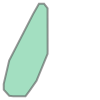

In [278]:
a_poly[0][2]

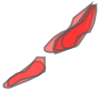

In [197]:
a_poly[8]

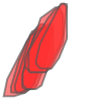

In [198]:
a_poly[0]

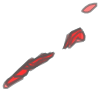

In [205]:
a_poly[6]

In [177]:
b_alt[8]

[array([array([249.01576], dtype=float32),
        array([249.01576], dtype=float32),
        array([249.01576], dtype=float32),
        array([249.01576], dtype=float32),
        array([249.01576], dtype=float32),
        array([249.01576], dtype=float32)], dtype=object)]

In [64]:
c = itertools.groupby(nums, key=lambda n: (n-min(nums))//20)

In [69]:
for _ in c:
    _

In [56]:
nums = b_alt[0]
for k, g in itertools.groupby(nums, key=lambda n: (n-min(nums))//20):
    print(k, list(g))

4.0 [398.95013]
2.0 [351.04987, 351.04987, 351.04987, 351.04987, 351.04987, 351.04987]
-0.0 [299.86877]


In [57]:
g

In [164]:
results_info[np.where(results_info[:, -1] >= 1)]

array([[2013,    1,    1,    4,   21,    1],
       [2013,    1,    1,    4,   26,    1],
       [2013,    1,    1,    4,   31,    1],
       [2013,    1,    1,    4,   37,    1],
       [2013,    1,    1,    4,   42,    1],
       [2013,    1,    1,    4,   47,    1],
       [2013,    1,    1,    4,   52,    1],
       [2013,    1,    1,    4,   57,    1],
       [2013,    1,    1,    5,    2,    1],
       [2013,    1,    1,    5,    7,    1],
       [2013,    1,    1,    5,   12,    1],
       [2013,    1,    1,    5,   17,    1],
       [2013,    1,    1,    5,   22,    1],
       [2013,    1,    1,    6,   22,    1],
       [2013,    1,    1,    6,   27,    1],
       [2013,    1,    1,    6,   32,    1],
       [2013,    1,    1,    6,   37,    1],
       [2013,    1,    1,    6,   42,    1],
       [2013,    1,    1,    6,   47,    1],
       [2013,    1,    1,    6,   52,    2],
       [2013,    1,    1,    6,   57,    1],
       [2013,    1,    1,    7,    2,    1],
       [20

In [118]:
poly_idx = np.where(((results_info[:, :4] == [2013,1,1,4]).all(axis = 1))&(results_info[:, -1]>0))
results_storm[78][:, 1].max()

299.86877

In [22]:
a = Polygon(results_storm[48][:, 2:])
b = Polygon(results_storm[78][:15, 2:])
c = Polygon(results_storm[78][15:, 2:])
d = MultiPolygon([b, c])

In [30]:
e = a.union(d)

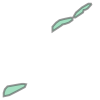

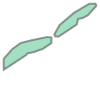

In [23]:
d

In [20]:
results_storm[78][:15, 2:]

array([[ 31.40996, -92.80135],
       [ 31.51729, -92.72745],
       [ 31.51774, -92.69327],
       [ 31.51765, -92.65702],
       [ 31.4629 , -92.65129],
       [ 31.27131, -92.6904 ],
       [ 31.12247, -92.7281 ],
       [ 31.01502, -92.80657],
       [ 30.90678, -92.92991],
       [ 30.90619, -92.96045],
       [ 30.9073 , -93.06986],
       [ 31.19425, -92.88127],
       [ 31.20611, -92.86221],
       [ 31.2938 , -92.84286],
       [ 31.40996, -92.80135]], dtype=float32)

In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import pickle
import os
from mpl_toolkits.basemap import Basemap
from descartes.patch import PolygonPatch
from shapely.geometry import Polygon, MultiPolygon, LineString, Point
import matplotlib.pyplot as plt
import matplotlib.patches as plt_patch
%matplotlib inline

In [23]:
storm = np.array([-90.19636,30.14955,
-90.13057,30.14924,
-90.11319,30.14612,
-90.07603,30.11336,
-89.99865,30.00349,
-89.99858,29.95069,
-90.00348,29.93358,
-90.11319,29.82584,
-90.132,29.82561,
-90.19666,29.82559,
-90.22652,29.82559,
-90.25725,29.82584,
-90.34293,29.86255,
-90.41887,29.93379,
-90.41958,29.95152,
-90.41958,30.02044,
-90.41887,30.03817,
-90.3798,30.07724,
-90.34293,30.10941,
-90.25813,30.1492,
-90.22681,30.14955,
-90.19636,30.14955])

detect = np.array([-90.5057,30.13346,
-90.43991,30.13315,
-90.42254,30.13004,
-90.38538,30.09727,
-90.30799,29.9874,
-90.30792,29.9346,
-90.31282,29.91749,
-90.42254,29.80975,
-90.44135,29.80952,
-90.506,29.8095,
-90.53586,29.8095,
-90.56659,29.80975,
-90.65228,29.84646,
-90.72821,29.9177,
-90.72892,29.93543,
-90.72892,30.00436,
-90.72821,30.02209,
-90.68915,30.06116,
-90.65228,30.09332,
-90.56747,30.13311,
-90.53616,30.13346,
-90.5057,30.13346])

In [24]:
storm = storm.reshape(-1,2)
detect = detect.reshape(-1,2)

In [14]:
storm = np.vstack((storm[::2], storm[1::2])).T
detect = np.vstack((detect[::2], detect[1::2])).T

In [25]:
storm_poly = Polygon(storm)
detect_poly = Polygon(storm)

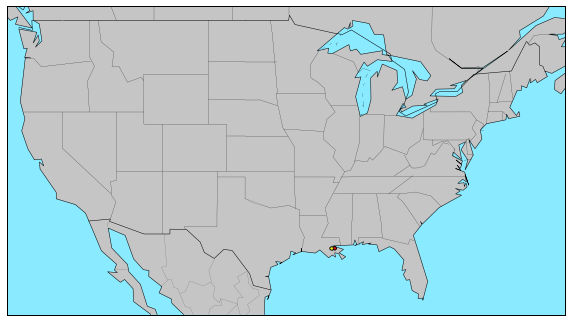

In [25]:
plt.figure(figsize=(10,6))
m = Basemap(llcrnrlon = -126,llcrnrlat = 23.5,urcrnrlon = -65,urcrnrlat = 50,projection='merc')
m.drawmapboundary(fill_color='#8aeaff')
m.fillcontinents(color='#c5c5c5', lake_color='#8aeaff')

m.drawcoastlines(linewidth=0.5)
m.drawcountries(linewidth=0.5)
m.drawstates(linewidth=0.1)
x,y = m(storm[:,0], storm[:,1])

x1,y1 = m(detect[:,0], detect[:,1])
xy = zip(x, y)
xy1 = zip(x1, y1)
st_Poly = plt_patch.Polygon( xy, facecolor='red', alpha=0.9)
de_Poly = plt_patch.Polygon( xy1, facecolor='yellow', alpha=0.9)

plt.gca().add_patch(st_Poly)
plt.gca().add_patch(de_Poly)

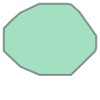

In [29]:
detect_poly

In [4]:
data = pickle.load(open(os.getcwd() + '/NCWF/one_hour.p', 'r'))